## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-12 18:25:50--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-12 18:25:50--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-K

In [5]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [6]:
CUDA_DEVICE_ID = 0  # change if needed

In [7]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.9MB/s]


Text(0.5, 1.0, 'Image label: 4')

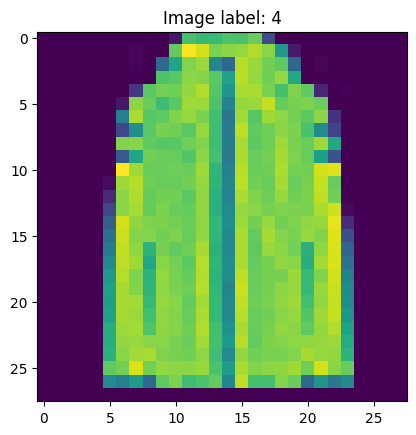

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [9]:
from typing import OrderedDict
# Creating model instance

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, dropout_p, pool, i):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            (f'conv', nn.Conv2d(in_c, out_c, kernel_size, padding="same")),
            (f'bnorm', nn.BatchNorm2d(out_c)),
            (f'drop', nn.Dropout2d(dropout_p)),
            (f'act', activation),
        ]))
        self.pool = pool
        self.i = i
        if in_c != out_c and self.i:
            self.conv1 = nn.Conv2d(in_c, out_c, 1)
        else:
            self.conv1 = nn.Identity()

    def forward(self, x):
        if self.i:
            return self.pool(self.conv1(x) + self.block(x))
        else:
            return self.pool(self.block(x))

class FashionMNISTModel(nn.Module):
    def __init__(
        self,
        input_size,
        num_conv_layers,
        kernel_sizes,
        hidden_size,
        activations,
        dropouts,
        poolings,
        output_size
    ):
        super(FashionMNISTModel, self).__init__()


        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        assert len(kernel_sizes) == num_conv_layers, f'provide {num_conv_layers} kernel_sizes or just one for all layers'

        assert isinstance(hidden_size, int), f'provide one hidden_size for all layers'
        hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers

        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        assert len(activations) == num_conv_layers, f'provide {num_conv_layers} activation functions or just one for all layers'

        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_conv_layers
        assert len(dropouts) == num_conv_layers, f'provide {num_conv_layers} dropout values or just one for all layers'

        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        assert len(poolings) == num_conv_layers, f'provide {num_conv_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_conv_layers)]) == num_conv_layers, \
               f'each pooling should be one of {available_poolings}'

        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_conv_layers)]

        self.conv_block = nn.Sequential(OrderedDict([
            (f'conv0', nn.Conv2d(in_channels=input_size[0], out_channels=hidden_sizes[0], kernel_size=3)),
            (f'bn0', nn.BatchNorm2d(hidden_sizes[0])),
            (f'activ0', nn.LeakyReLU(0.2)),
        ]))
        self.layers = nn.Sequential(OrderedDict(
            [
                (f'block{i}', residual_block(
                    hidden_sizes[i],
                    hidden_sizes[i + 1],
                    kernel_sizes[i],
                    activations[i],
                    dropouts[i],
                    self.poolings[i],
                    i
                )) for i in range(num_conv_layers)
            ]
        ))
        self.head = nn.Sequential(OrderedDict([
            (f'flatten', nn.Flatten()),
            (f'hid2out', nn.Linear(hidden_sizes[-1] * 3 * 3, output_size)),
            (f'log_softmax', nn.LogSoftmax(dim=-1)),
        ]))
        # self.net = nn.Sequential(*[self.conv_block, self.layers, self.head])

    def forward(self, x):
        # return self.net(x)
        out = self.conv_block(x)
        out = self.layers(out)
        out = self.head(out)
        return out

In [11]:
classes = len(train_fmnist_data.classes)
classes

10

In [12]:
img_size = train_fmnist_data.data[0].unsqueeze(0).shape
img_size

torch.Size([1, 28, 28])

In [13]:
# Creating model instance
# model_task_1 = None
# your code here
model_task_1 = FashionMNISTModel(
    input_size = img_size,
    num_conv_layers = 3,
    kernel_sizes = 3,
    hidden_size = 32,
    activations = nn.LeakyReLU(0.2),
    dropouts = 0.2,
    poolings = nn.AvgPool2d,
    output_size = classes
)

Не забудьте перенести модель на выбранный `device`!

In [15]:
model_task_1 = model_task_1.to(device)

Локальные тесты для проверки вашей модели доступны ниже:

In [16]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
# your code here

In [17]:
import IPython
from math import ceil

def train_loop(model, dataloader, optim, loss_fn, scheduler=None, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    model.train()

    train_loss, train_acc = [], []

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)
        train_loss.append(loss.item())
        acc = (preds.argmax(1) == y).type(torch.float).sum().item()
        train_acc.append(acc / y.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == batches:
            out.update(f'[Acc: {np.mean(train_acc)} Loss: {np.mean(train_loss):>8f}')
    if scheduler:
        try:
            scheduler.step()
        except:
            scheduler.step(loss)

    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def eval_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):
    model.eval()

    val_loss, val_acc = [], []

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)
            val_loss.append(loss.item())
            acc = (preds.argmax(1) == y).type(torch.float).sum().item()
            val_acc.append(acc / y.size(0))

    print(f"Validation accuracy: {(100*np.mean(val_acc)):>0.1f}%, Validation loss: {np.mean(val_loss):>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))

    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}

In [18]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):

    fig = plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)) + 0.5, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)) + 0.5, train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)) + 1, val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')

    fig.tight_layout()
    plt.show()

Epoch 1
-------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


'[Acc: 0.8040333333333334 Loss: 0.545596'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.8%, Validation loss: 0.379211 

Epoch 2
-------------------------------


'[Acc: 0.8625166666666667 Loss: 0.385393'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.4%, Validation loss: 0.351689 

Epoch 3
-------------------------------


'[Acc: 0.8721833333333333 Loss: 0.353567'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.8%, Validation loss: 0.341110 

Epoch 4
-------------------------------


'[Acc: 0.8815 Loss: 0.332500'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 89.0%, Validation loss: 0.309882 

Epoch 5
-------------------------------


'[Acc: 0.8867666666666667 Loss: 0.316260'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 89.5%, Validation loss: 0.296844 

Epoch 6
-------------------------------


'[Acc: 0.8902333333333333 Loss: 0.307635'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 89.6%, Validation loss: 0.293292 

Epoch 7
-------------------------------


'[Acc: 0.89155 Loss: 0.301180'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.9%, Validation loss: 0.300032 

Epoch 8
-------------------------------


'[Acc: 0.8946666666666667 Loss: 0.292955'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.3%, Validation loss: 0.279934 

Epoch 9
-------------------------------


'[Acc: 0.8955166666666666 Loss: 0.289375'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.4%, Validation loss: 0.272723 

Epoch 10
-------------------------------


'[Acc: 0.8972833333333333 Loss: 0.284114'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.1%, Validation loss: 0.276834 

Epoch 11
-------------------------------


'[Acc: 0.9006666666666666 Loss: 0.279330'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.5%, Validation loss: 0.269794 

Epoch 12
-------------------------------


'[Acc: 0.9024 Loss: 0.274387'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.4%, Validation loss: 0.268935 

Epoch 13
-------------------------------


'[Acc: 0.9028833333333334 Loss: 0.272323'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.7%, Validation loss: 0.263834 

Epoch 14
-------------------------------


'[Acc: 0.9050166666666667 Loss: 0.265736'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.8%, Validation loss: 0.257206 

Epoch 15
-------------------------------


'[Acc: 0.9042166666666667 Loss: 0.266032'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 90.5%, Validation loss: 0.262251 



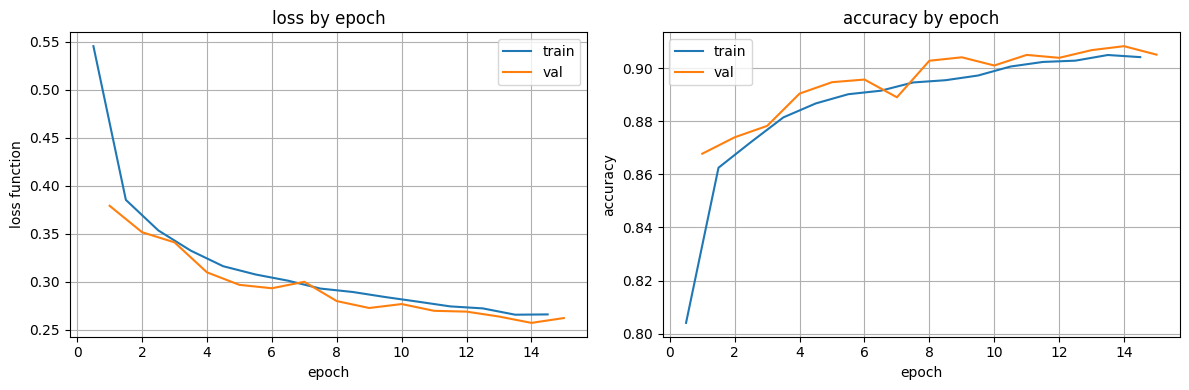

In [20]:
from tqdm.notebook import tqdm

model = model_task_1
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), 1e-3, [0.9, 0.999])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,
    verbose=True,
)
epochs = 15

train_loss, train_acc, train_lr = [], [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, train_data_loader, optimizer, loss_fn, scheduler, history_loss=train_loss, history_acc=train_acc)
    eval_loop(model, test_data_loader, loss_fn, history_loss=val_loss, history_acc=val_acc)
    for param_group in optimizer.param_groups:
        train_lr.append(param_group['lr'])
plot_learning_process(train_loss, train_acc, val_loss, val_acc)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [21]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92123


In [22]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.905


Проверка, что необходимые пороги пройдены:

In [23]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [24]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!